<div style="text-align: center;">
<h1>Reel Realities: How Gender and Age Shape Success Across Box Office and Streaming Platforms</h1>
</div>

### <u>Imports</u>

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

### 1. <u>Data cleaning and pre-processing</u>

#### 1.1 CMU Dataset

#### 1.2 IMDB Dataset

We will use two IMDB datasets to decribe movies:
1. "title.ratings.tsv" gives us the ratings of the movies as voted by viewers. 
2. "title.basics.tsv", indexes into "title.ratings.tsv" using a alphanumeric unique identifier of the title. It gives general information about the movie such as runtime, release date and adult rating.

In [2]:
# Loading the datasets. Null values are represented using "\N".
IMDB_ratings_df = pd.read_csv("data/IMDB/title.ratings.tsv", sep="\t", na_values="\\N")
IMDB_basics_df = pd.read_csv("data/IMDB/title.basics.tsv", sep="\t", na_values="\\N", low_memory=False)

In [3]:
IMDB_ratings_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2100
1,tt0000002,5.6,282
2,tt0000003,6.5,2119
3,tt0000004,5.4,182
4,tt0000005,6.2,2850


In [4]:
IMDB_basics_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0.0,1894.0,NaN,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0.0,1892.0,NaN,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0.0,1892.0,NaN,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0.0,1892.0,NaN,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0.0,1893.0,NaN,1,"Comedy,Short"


In [5]:
# Checking the lengths of the datasets
print(f"Length of IMDB_ratings_df: {len(IMDB_ratings_df):,}\n"
      f"Length of IMDB_basics_df: {len(IMDB_basics_df):,}\n")

Length of IMDB_ratings_df: 1,498,615
Length of IMDB_basics_df: 11,235,767



Before dealing with the null values we will merge the dataframes together using the alphanumeric unique identifier.

In [6]:
IMDB_merged_df = pd.merge(IMDB_ratings_df, IMDB_basics_df, how="inner", left_on="tconst", right_on="tconst")

print(f"The resulting merged dataframe has length: {len(IMDB_merged_df):,}")
IMDB_merged_df.head()

The resulting merged dataframe has length: 1,498,615


,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,5.7,2100,short,Carmencita,Carmencita,0.0,1894.0,NaN,1,"Documentary,Short"
1,tt0000002,5.6,282,short,Le clown et ses chiens,Le clown et ses chiens,0.0,1892.0,NaN,5,"Animation,Short"
2,tt0000003,6.5,2119,short,Poor Pierrot,Pauvre Pierrot,0.0,1892.0,NaN,5,"Animation,Comedy,Romance"
3,tt0000004,5.4,182,short,Un bon bock,Un bon bock,0.0,1892.0,NaN,12,"Animation,Short"
4,tt0000005,6.2,2850,short,Blacksmith Scene,Blacksmith Scene,0.0,1893.0,NaN,1,"Comedy,Short"


We can see that every row in IMDB_ratings_df is also in IMDB_basics_df.

These dataframes do not only have movies but also short movies, tv shows, episodes. The next step is thus to filter only movies.

In [7]:
IMDB_merged_df = IMDB_merged_df[IMDB_merged_df["titleType"] == "movie"]

print(f"There are {len(IMDB_merged_df):,} movies in the resulting dataframe.")
IMDB_merged_df.head()

There are 319,879 movies in the resulting dataframe.


,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,5.4,216,movie,Miss Jerry,Miss Jerry,0.0,1894.0,NaN,45,Romance
144,tt0000147,5.2,540,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,NaN,100,"Documentary,News,Sport"
339,tt0000502,4.1,19,movie,Bohemios,Bohemios,0.0,1905.0,NaN,100,NaN
374,tt0000574,6.0,938,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,NaN,70,"Action,Adventure,Biography"
384,tt0000591,5.7,28,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,NaN,90,Drama


We can now look at null values in the merged IMDB dataframe.

In [8]:
# Checking the percentage of null values in the dataset.
n_null_IMDB = ((IMDB_merged_df.isnull().sum() / len(IMDB_merged_df)) * 100).apply(lambda x: f"{x:,.2f}%")

print(
    f"Percentage of null values per column:\n"
    f"IMDB_ratings_df:\n{n_null_IMDB}"
)

Percentage of null values per column:
IMDB_ratings_df:
tconst              0.00%
averageRating       0.00%
numVotes            0.00%
titleType           0.00%
primaryTitle        0.00%
originalTitle       0.00%
isAdult             0.00%
startYear           0.01%
endYear           100.00%
runtimeMinutes     10.04%
genres              3.32%
dtype: object


The end year is always missing. Other than that the proportion of missing values is very small (< 10%). End year does not have any useful information for our intended analysis and can thus be dropped. We can also drop the titleType column since we know they are all movies after the filtering that was done above.

In [9]:
IMDB_merged_df = IMDB_merged_df.drop(columns=["endYear", "titleType"], axis=1)
IMDB_merged_df.head()

,tconst,averageRating,numVotes,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
8,tt0000009,5.4,216,Miss Jerry,Miss Jerry,0.0,1894.0,45,Romance
144,tt0000147,5.2,540,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897.0,100,"Documentary,News,Sport"
339,tt0000502,4.1,19,Bohemios,Bohemios,0.0,1905.0,100,NaN
374,tt0000574,6.0,938,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,70,"Action,Adventure,Biography"
384,tt0000591,5.7,28,The Prodigal Son,L'enfant prodigue,0.0,1907.0,90,Drama


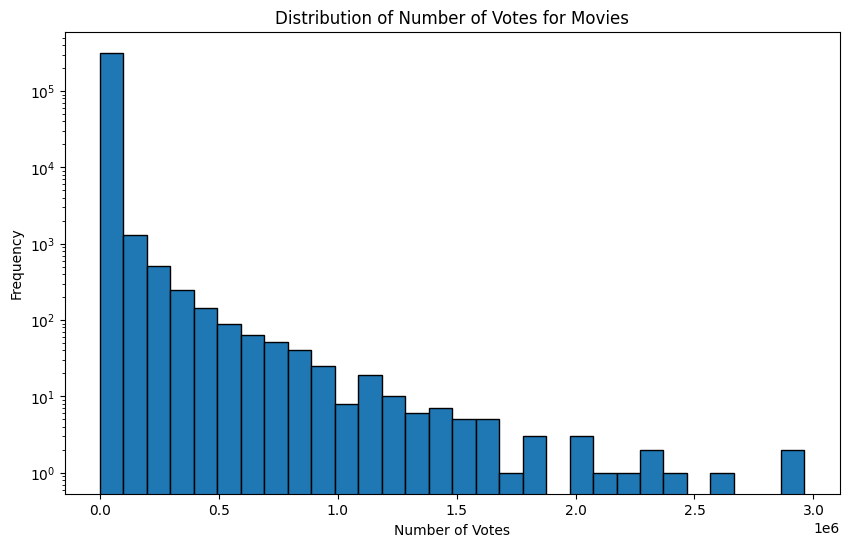

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(IMDB_merged_df['numVotes'].dropna(), bins=30, edgecolor='black')
plt.title("Distribution of Number of Votes for Movies")
plt.xlabel("Number of Votes")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

### <u>Our success metric</u>

### 2. <u>Gender and age vs success BLABLABLA</u>

### 3. <u>How does it compare to streaming platforms? Are movies made for these platforms different? Have box office movies adapted since the rise of streaming?</u>

### 4. <u>What are the social reasons behind the presence of female characters in movies? Is it due to sexualization or genuine equality of representation?</u>

### 5. <u>Are these results different when looking at the acclaim (ratings) of a movie instead of revenue?</u>